<a href="https://colab.research.google.com/github/Konstantin-Iakovlev/2021-Optimization_Project/blob/main/SQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stochastic Quasi Newton methods for Neural Networks 

In [90]:
import numpy as np
from stochqn import oLBFGS
from stochqn import SQN
from sklearn.linear_model._logistic import _logistic_loss_and_grad, _logistic_grad_hess
from sklearn.datasets import load_digits
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=BIGGER_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [81]:
def batch(iterable_X, iterable_y, n=1):
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]

def obj_fun(w, X, y, sample_weight=None, reg_param=1.0):
    return _logistic_loss_and_grad(w, X, y, reg_param, sample_weight)[0]

def grad_fun(w, X, y, sample_weight=None, reg_param=1.0):
    # print(w.shape, X.shape, y.shape)
    # (65,) (72, 64) (72,)
    return _logistic_loss_and_grad(w, X, y, reg_param, sample_weight)[1]

def hess_fun(w, vec, X, y, sample_weight=None, reg_param=1.0):
    return _logistic_grad_hess(w, X, y, reg_param, sample_weight)[1](vec)

def pred_fun(w, X):
	return 1 / (1 + np.exp(-X.dot(w[:X.shape[1]]) - w[-1]))

digits = load_digits()
X = digits["data"]
y = (digits["target"] == 3).astype('int64') ### picked one class at random
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(f'X shape = {X.shape}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

np.random.seed(1)
w0 = np.random.normal(size = X.shape[1] + 1)


optimizer = oLBFGS(x0=w0, grad_fun=grad_fun, obj_fun=obj_fun, nepochs=1,
                   pred_fun=pred_fun, step_size=5e-6)
sqn_optimizer = SQN(x0=w0, grad_fun=grad_fun, obj_fun=obj_fun, nepochs=1,
                    pred_fun=pred_fun, hess_vec_fun=hess_fun, step_size=5e-6)
# initial loss
print('initial', log_loss(y_test, optimizer.predict(X_test)), log_loss(y_test, sqn_optimizer.predict(X_test)))

Q_arr = []
Q_sgd = []
Q_sqn = []
Q_sqn.append(log_loss(y_test, sqn_optimizer.predict(X_test)))
Q_arr.append(log_loss(y_test, optimizer.predict(X_test)))
np.random.seed(1)
for i in range(200):
    optimizer.partial_fit(X_train, y_train,sample_weight=None,
                          additional_kwargs={"reg_param" : 1.0})
    Q_arr.append(log_loss(y_test, optimizer.predict(X_test)))
np.random.seed(1)
for i in range(200):
    sqn_optimizer.partial_fit(X_train, y_train,sample_weight=None,
                          additional_kwargs={"reg_param" : 1.0})
    Q_sqn.append(log_loss(y_test, sqn_optimizer.predict(X_test)))

X shape = (1797, 64)
initial 2.256728814529451 2.256728814529451


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


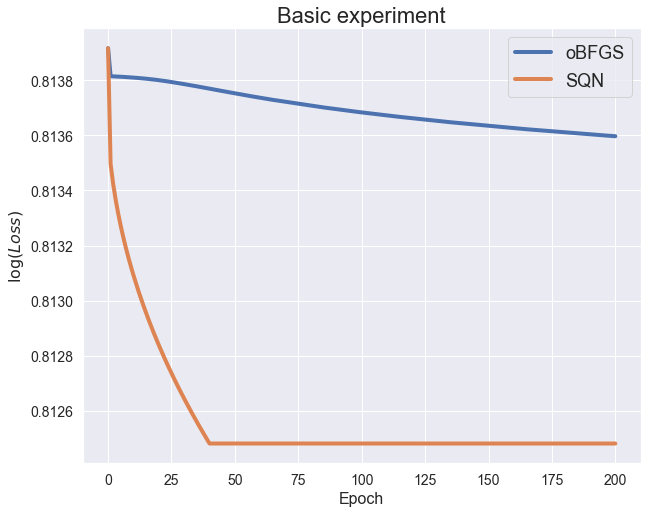

In [91]:
plt.figure(figsize=(10, 8))

plt.plot(np.log(np.array(Q_arr)), label='oBFGS', linewidth=4)
plt.plot(np.log(np.array(Q_sqn)), label='SQN', linewidth=4)
plt.xlabel('Epoch')
plt.ylabel('$\log(Loss)$')
plt.legend()
plt.title('Basic experiment', fontsize=22)
plt.savefig('basic_exp.eps', dpi=200)
plt.show()

### Main experiment



In [50]:
! git clone https://github.com/cthl/sqgn
! python sqgn/mnist_tf/mnist_tf.py -opt_name sqn -seed 1

/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


sqn = (0.1293519, 0.1118964, 0.1114302, 0.1112803)
sgd = (0.2784801, 0.1521614, 0.1250924, 0.1052487)


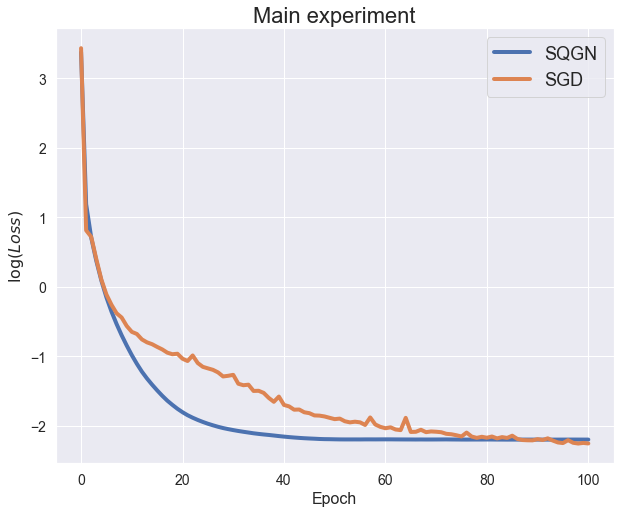

In [93]:
import re
import numpy as np

def get_acc(filename, test=True):
    acc_arr = []
    pattern = 'test loss'
    if not test:
        pattern = 'train loss'
    with open(filename, 'r') as fin:
        for line in fin:
            found = re.findall(pattern, line)
            if found:
                # acc_arr.append(float(found[0][-4:]))
                acc_arr.append(float(line.split(' ')[-1]))
    return np.array(acc_arr)

plt.figure(figsize=(10, 8))
# test loss
sqn_acc = get_acc('sqn_nn.log')
print(f'sqn = {sqn_acc[29], sqn_acc[49], sqn_acc[69], sqn_acc[-1]}')
plt.plot(np.log(sqn_acc), label='SQGN', linewidth=4)
sgd_acc = get_acc('sgd_nn.log')
print(f'sgd = {sgd_acc[29], sgd_acc[49], sgd_acc[69], sgd_acc[-1]}')
plt.plot(np.log(sgd_acc), label='SGD', linewidth=4)
# train loss
# sqn_acc = get_acc('sqn_nn.log', test=False)
# print(f'sqn = {sqn_acc[29], sqn_acc[49], sqn_acc[69], sqn_acc[-1]}')
# plt.plot(np.log(sqn_acc), label='SQGN: train')
# sgd_acc = get_acc('sgd_nn.log', test=False)
# print(f'sgd = {sgd_acc[29], sgd_acc[49], sgd_acc[69], sgd_acc[-1]}')
# plt.plot(np.log(sgd_acc), label='SGD: train')
#
# print(sqn_acc, sgd_acc)


plt.xlabel('Epoch', fontsize=MEDIUM_SIZE)
plt.ylabel('$\log(Loss)$', fontsize=MEDIUM_SIZE)
plt.legend()
plt.title('Main experiment', fontsize=22)
plt.savefig('main_exp.eps', dpi=200)
plt.show()
